# Trading Strategy Based on Z-Score of Returns

Notebook by Nicholas Tan Tee Khoon
*** 

This report explores a quantitative trading strategy applied to SPY, a S&P500 index fund. The strategy leverages the rolling z-score of daily returns to generate trading signals, aiming to capture mean-reverting behavior and profit from over-extended price movements. The primary objective is to assess the effectiveness of this approach by evaluating its risk-adjusted returns over historical data.

## Data and Preprocessing

The dataset used in this study is sourced from historical SPY price data stored in an Excel file. The 'Date' column is set as the index to sort chronologically. This ensures accurate time series analysis. Daily returns are calculated as the percentage change of consecutive closing prices, establishing the base variable for further statistical analysis.

- ### Download SPY data from yahoo finance
This is done with a starting date of 1 January 2020, and en ending date of the current day. 




In [8]:
import yfinance as yf
import pandas as pd
from datetime import date

# Parameters for download
ticker = 'SPY'
start_date = '2020-01-01'
today = date.today()

df = yf.download(ticker, start=start_date, end=today)
df

AttributeError: module 'yfinance' has no attribute 'download'

- ### Format column headers 
Inspecting the data, we see that Yahoo finance downloads data with multi index column headers which make it unnecessary for our calculations. Thus:
- `get_level_values()` is used to drop the `Ticker | TQQQ | TQQQ | ... | TQQQ` row
- `reset_index()` is used to drop the `Date` row

In [ ]:
df.columns = df.columns.get_level_values(0)  # Flatten MultiIndex columns
df = df.reset_index() # Drop Date row
df


Price,Date,Close,High,Low,Open,Volume
0,2020-01-02,299.406372,299.424822,297.249787,298.180631,59151200
1,2020-01-03,297.139313,298.272915,295.931994,295.987288,77709700
2,2020-01-06,298.272888,298.355831,295.249950,295.369765,55653900
3,2020-01-07,297.434174,298.180683,296.982561,297.701423,40496400
4,2020-01-08,299.019379,300.245120,297.378898,297.627725,68296000
...,...,...,...,...,...,...
1420,2025-08-27,646.630005,647.369995,644.419983,644.570007,48341100
1421,2025-08-28,648.919983,649.479980,645.340027,647.239990,61519500
1422,2025-08-29,645.049988,647.840027,643.140015,647.469971,74522200
1423,2025-09-02,640.270020,640.489990,634.919983,637.500000,81983500


## Methodology

- ### Rolling Window and Z-Score Calculation
The core concept involves computing a rolling mean and standard deviation of the returns over a lookback period of 21 trading days (approximately one month). The z-score $z_t$ is then derived by standardising the returns relative to this moving window:
$$z_t=\frac{r_t-\mu_t}{\sigma_t}$$
where $r_t$ is the return at time $t$, $\mu_t$ the rolling mean, and $\sigma_t$ the rolling standard deviation. This standardisation normalises the return series, allowing identification of statistically significant deviations from recent behavior.





In [ ]:
lookback = 21 # Rolling window period

# Calculate returns as percentage change in closing price from previous day
df['returns'] = df['Close'].pct_change()

# Calculate rolling mean, std dev, and zscore for returns
df['roll_mean'] = df['returns'].rolling(window=lookback).mean()
df['roll_std'] = df['returns'].rolling(window=lookback).std()
df['zscore'] = (df['returns'] - df['roll_mean']) / df['roll_std']
df.tail()

Price,Date,Close,High,Low,Open,Volume,returns,roll_mean,roll_std,zscore
1420,2025-08-27,646.630005,647.369995,644.419983,644.570007,48341100,0.002279,0.000872,0.007451,0.188846
1421,2025-08-28,648.919983,649.479980,645.340027,647.239990,61519500,0.003541,0.001100,0.007456,0.327437
1422,2025-08-29,645.049988,647.840027,643.140015,647.469971,74522200,-0.005964,0.000995,0.007543,-0.922526
1423,2025-09-02,640.270020,640.489990,634.919983,637.500000,81983500,-0.007410,0.001422,0.006717,-1.314893
1424,2025-09-03,643.739990,644.210022,640.460022,642.669983,70741100,0.005420,0.000957,0.006017,0.741725


- ### Signal Generation
**Entry Signal** 

The idea is that when $z_t$ is too low, we execute a long order, anticipating mean reversion from an oversold state. Conversely, when $z_t$ is too high, we execute a sell order, reflecting an overbought scenario. Namely, these two thresholds guide the trading decisions:
- a long entry threshold at $z_t=-0.5$
- a short entry threshold at $z_t=+0.5$

**Exit Signal**

When $z_t$ reverts beyond zero, close respective long or short positions.


In [ ]:
long_entry_threshold = -0.5  # zscore threshold for going long
short_entry_threshold = 0.5  # zscore threshold for going short

# Generate discrete long and short entry signals
df['long_entry'] = 0
df['short_entry'] = 0
df.loc[df['zscore'] < long_entry_threshold, 'long_entry'] = 1      # Long entry signal (+1)
df.loc[df['zscore'] > short_entry_threshold, 'short_entry'] = 1    # Short entry signal (+1)

# Generate exit signals that clear positions
df['long_exit'] = 0
df['short_exit'] = 0
df.loc[df['zscore'] > 0, 'long_exit'] = 1     # Clear all longs when zscore > 0
df.loc[df['zscore'] < 0, 'short_exit'] = 1    # Clear all shorts when zscore < 0
df.tail()

Price,Date,Close,High,Low,Open,Volume,returns,roll_mean,roll_std,zscore,long_entry,short_entry,long_exit,short_exit
1420,2025-08-27,646.630005,647.369995,644.419983,644.570007,48341100,0.002279,0.000872,0.007451,0.188846,0,0,1,0
1421,2025-08-28,648.919983,649.479980,645.340027,647.239990,61519500,0.003541,0.001100,0.007456,0.327437,0,0,1,0
1422,2025-08-29,645.049988,647.840027,643.140015,647.469971,74522200,-0.005964,0.000995,0.007543,-0.922526,1,0,0,1
1423,2025-09-02,640.270020,640.489990,634.919983,637.500000,81983500,-0.007410,0.001422,0.006717,-1.314893,1,0,0,1
1424,2025-09-03,643.739990,644.210022,640.460022,642.669983,70741100,0.005420,0.000957,0.006017,0.741725,0,1,1,0


In [ ]:
print(df.columns)

Index(['Date', 'Close', 'High', 'Low', 'Open', 'Volume', 'returns',
       'roll_mean', 'roll_std', 'zscore', 'long_entry', 'short_entry',
       'long_exit', 'short_exit'],
      dtype='object', name='Price')


- ### Position Management

Positions are accumulated over time, increasing by one unit upon each entry signal unless an exit signal resets the position to zero. Namely:

if `long_exit == 1` -> `long_pos = 0`

if `short_exit == 1` -> `short_exit = 0`

else today's `long_pos` = yesterday's `long_pos` + today's `long_pos`

The net position is the difference between total long and short positions, lagged by one day to mitigate lookahead bias.



In [ ]:
# Initialise position columns
df['long_pos'] = 0
df['short_pos'] = 0

# To propagate the reset effect forward in time for longs:
for i in range(1, len(df)):
    if df['long_exit'].iloc[i] == 1:
        df.at[df.index[i], 'long_pos'] = 0
    else:
        # If no exit today, position is previous day's position plus today's entry
        if i > 0:
            df.at[df.index[i], 'long_pos'] = df.at[df.index[i-1], 'long_pos'] + df['long_entry'].iloc[i]

# Propagate the reset effect forward in time for shorts:
for i in range(1, len(df)):
    if df['short_exit'].iloc[i] == 1:
        df.at[df.index[i], 'short_pos'] = 0
    else:
        if i > 0:
            df.at[df.index[i], 'short_pos'] = df.at[df.index[i-1], 'short_pos'] + df['short_entry'].iloc[i]

# Net position = long positions - short positions
df['net_position'] = df['long_pos'] - df['short_pos']

# Lag position by one day to avoid lookahead bias
df['net_position_lagged'] = df['net_position'].shift()

df.tail()

Price,Date,Close,High,Low,Open,Volume,returns,roll_mean,roll_std,zscore,long_entry,short_entry,long_exit,short_exit,long_pos,short_pos,net_position,net_position_lagged
1420,2025-08-27,646.630005,647.369995,644.419983,644.570007,48341100,0.002279,0.000872,0.007451,0.188846,0,0,1,0,0,0,0,0.0
1421,2025-08-28,648.919983,649.479980,645.340027,647.239990,61519500,0.003541,0.001100,0.007456,0.327437,0,0,1,0,0,0,0,0.0
1422,2025-08-29,645.049988,647.840027,643.140015,647.469971,74522200,-0.005964,0.000995,0.007543,-0.922526,1,0,0,1,1,0,1,0.0
1423,2025-09-02,640.270020,640.489990,634.919983,637.500000,81983500,-0.007410,0.001422,0.006717,-1.314893,1,0,0,1,2,0,2,1.0
1424,2025-09-03,643.739990,644.210022,640.460022,642.669983,70741100,0.005420,0.000957,0.006017,0.741725,0,1,1,0,0,1,-1,2.0


- ### Strategy Returns and Performance Metric

Strategy returns are computed considering the net position multiplied by the next day's actual returns. The Sharpe ratio, a standard risk-adjusted performance measure, is calculated by annualizing the strategy's mean returns relative to the volatility:
$$Sharpe\ Ratio = \sqrt{252} \times \frac{\mu_r}{\sigma_r}$$
where $\mu_r$ and $\sigma_r$ are the mean and standard deviation of daily strategy returns. Because standard deviation scales with the square root of time, the Sharpe ratio is multiplied by $\sqrt{252}$ to get the annualised Sharpe ratio.

In [ ]:
import numpy as np

# Difference in position
transaction_cost = 0.0
df['position_diff'] = df['net_position_lagged'].diff().fillna(0)

# Calculate strategy daily returns
df['strategy_return'] = df['net_position_lagged'] * df['returns']

# Sharpe ratio
sharpe = np.sqrt(252) * df['strategy_return'].mean() / df['strategy_return'].std()
print("Sharpe Ratio:", sharpe)

# Check the signals and positions
df[['long_entry', 'short_entry', 'long_exit', 'short_exit',
          'long_pos', 'short_pos', 'net_position', 'net_position_lagged', 'strategy_return']].tail(10)

Sharpe Ratio: 0.5884753476631822


Price,long_entry,short_entry,long_exit,short_exit,long_pos,short_pos,net_position,net_position_lagged,strategy_return
1415,0,0,0,1,2,0,2,2.0,-0.005314
1416,1,0,0,1,3,0,3,2.0,-0.008024
1417,0,1,1,0,0,1,-1,3.0,0.046070
1418,1,0,0,1,1,0,1,-1.0,0.004401
1419,0,0,1,0,0,0,0,1.0,0.004187
1420,0,0,1,0,0,0,0,0.0,0.000000
1421,0,0,1,0,0,0,0,0.0,0.000000
1422,1,0,0,1,1,0,1,0.0,-0.000000
1423,1,0,0,1,2,0,2,1.0,-0.007410
1424,0,1,1,0,0,1,-1,2.0,0.010839


- ### Visualising the data

Assume a beginning capital of $10,000. Use `matplotlib.pyplot` to plot the cumulative sum on a graph. The plot is compared to the benchmark buy-and-hold strategy.

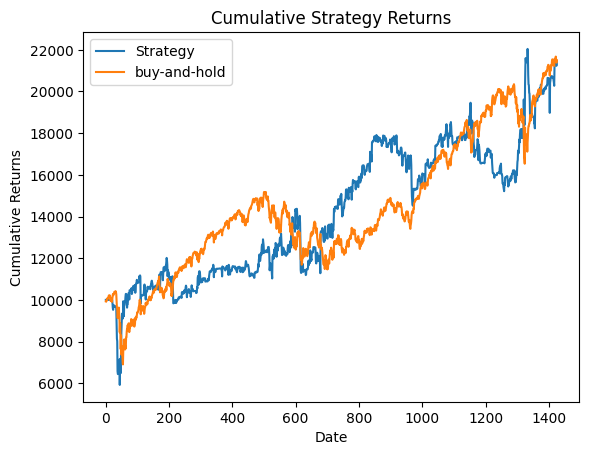

In [ ]:
import matplotlib.pyplot as plt

starting_capital = 10000

# Plot cumulative strategy returns
plt.title('Cumulative Strategy Returns')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.plot(starting_capital * (np.cumprod(1 + df['strategy_return'])), label='Strategy')
plt.plot(starting_capital * np.cumprod(1 + df['returns']), label="buy-and-hold")  # Benchmark: Buy and hold
plt.legend()
plt.show()


## Conclusion

The mean reversion trading strategy implemented in this study reveals insightful contrasts when compared to a straightforward buy-and-hold approach. While both methods deliver somewhat comparable returns in aggregate, mean reversion requires more nuanced execution and entails greater operational complexity. This is primarily due to the need for timely entry and exit signals based on statistical deviations, which can be sensitive to parameter choices and market conditions.

A notable finding is the differing efficacy of the strategy across asset classes. When tested on highly volatile instruments such as the triple-leveraged ETF TQQQ, mean reversion underperforms significantly. The amplified price fluctuations in leveraged ETFs increase the noise-to-signal ratio, making reliable mean reversion signals harder to discern and leading to more frequent false entries or exits. This is consistent with financial literature suggesting that leveraged products tend to exhibit path-dependent behaviors that challenge traditional mean reversion assumptions.

In contrast, applying the strategy to well-established blue-chip equities such as Apple (AAPL), Microsoft (MSFT), and Alphabet (GOOGL) yields markedly improved results. These stocks typically exhibit more stable price dynamics and less extreme volatility, promoting clearer mean reversion patterns. Empirical research shows that large-cap stocks often demonstrate short-term return autocorrelations consistent with mean reversion, especially following earnings announcements or macroeconomic shifts.

Ultimately, while mean reversion strategies can offer an edge under the right conditions, their success heavily depends on asset selection, parameter tuning, and market context. Traders and quantitative analysts should exercise caution when applying such strategies to leveraged or highly volatile securities and consider blending mean reversion with other risk management techniques to enhance robustness.

This nuanced understanding underscores the importance of aligning strategy design with the specific characteristics of the underlying assets to sustainably capture statistical arbitrage opportunities.


## Improvements to Research

This is an ideal set up where transaction costs have not been factored. This can be easily factored in by first calculating the difference in position for each day, then multiplying by a cost factor. The new Sharpe ratio and graph can be obtained as aforementioned with all other factors fixed.

In [ ]:
import numpy as np

transaction_cost = 0.0005 # Cost per trade of single stock
df['position_diff'] = df['net_position_lagged'].diff().fillna(0)

# Calculate strategy daily returns
df['strategy_return'] = df['net_position_lagged'] * df['returns'] - transaction_cost * df['position_diff'].abs()

# Sharpe ratio
sharpe = np.sqrt(252) * df['strategy_return'].mean() / df['strategy_return'].std()
print("Sharpe Ratio:", sharpe)

# Check the signals and positions
df[['long_entry', 'short_entry', 'long_exit', 'short_exit',
          'long_pos', 'short_pos', 'net_position', 'net_position_lagged', 'strategy_return']].tail(10)

df.tail()

Sharpe Ratio: 0.12514656603897817


Price,Date,Close,High,Low,Open,Volume,returns,roll_mean,roll_std,zscore,long_entry,short_entry,long_exit,short_exit,long_pos,short_pos,net_position,net_position_lagged,position_diff,strategy_return
1420,2025-08-27,646.630005,647.369995,644.419983,644.570007,48341100,0.002279,0.000872,0.007451,0.188846,0,0,1,0,0,0,0,0.0,-1.0,-0.000500
1421,2025-08-28,648.919983,649.479980,645.340027,647.239990,61519500,0.003541,0.001100,0.007456,0.327437,0,0,1,0,0,0,0,0.0,0.0,0.000000
1422,2025-08-29,645.049988,647.840027,643.140015,647.469971,74522200,-0.005964,0.000995,0.007543,-0.922526,1,0,0,1,1,0,1,0.0,0.0,-0.000000
1423,2025-09-02,640.270020,640.489990,634.919983,637.500000,81983500,-0.007410,0.001422,0.006717,-1.314893,1,0,0,1,2,0,2,1.0,1.0,-0.007910
1424,2025-09-03,643.739990,644.210022,640.460022,642.669983,70741100,0.005420,0.000957,0.006017,0.741725,0,1,1,0,0,1,-1,2.0,1.0,0.010339


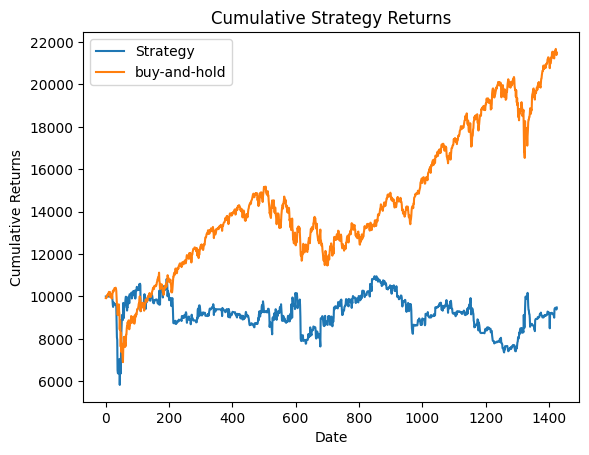

In [ ]:
import matplotlib.pyplot as plt

starting_capital = 10000

# Plot cumulative strategy returns
plt.title('Cumulative Strategy Returns')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.plot(starting_capital * (np.cumprod(1 + df['strategy_return'])), label='Strategy')
plt.plot(starting_capital * np.cumprod(1 + df['returns']), label="buy-and-hold")  # Benchmark: Buy and hold
plt.legend()
plt.show()


Suddenly results dont show anymore. 

## Strategy Refinement and Future Ideas

One of the critical observations from the strategy testing is that **transaction costs have a significant negative impact on performance**. Due to the frequent trading involved in mean reversion strategies, the cumulative transaction costs often outweigh the modest returns generated. This is a well-documented challenge in quantitative trading, where high turnover strategies can suffer from erosion of profits through commissions, slippage, and other fees.

Given this, future refinements should focus on reducing trading frequency or optimising entry and exit parameters to minimise transaction costs without sacrificing return potential. For example, **tweaking thresholds such as the z-score entry and exit points may help in balancing signal sensitivity with cost efficiency**.

Additional directions include:
- Implementing **dynamic threshold adjustments** based on volatility or market regime.
- Exploring **longer lookback windows** to reduce false signals and unnecessary trades.
- Considering **trade batching or limiting position adjustments** to cut down on excessive turnover.
- Incorporating **transaction cost models directly into strategy optimisation**, enabling a more realistic performance evaluation and parameter selection.

By carefully addressing transaction costs and refining parameters, mean reversion strategies can achieve more sustainable and robust performance, especially in less volatile, liquid markets.
